# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the sentence. Through the weighted average, workers and relations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the relation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across sentences. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-sentence agreement $WSA(i)$.

$$ WQS(i) = WSA(i) \; WWA(i) .$$

### Worker-Sentence Agreement

The worker-sentence agreement $WSA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the sentences they have worked on, weighted by the sentence and relation quality. It calculates how much a worker disagrees with the crowd on a sentence basis. Through the weighted average, sentences and relations with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{s \in sentences(i)} Wcos(WorkVec(i,s), MediaUnitVec(s) - WorkVec(i, s)) \; UQS(s)}{\sum_{s \in sentences(i)} UQS(s)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same sentences as worker $i$, weighted by the worker and relation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and relations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(s \in sentences(i))} Wcos(WorkVec(i, s), WorkVec(j, s)) \; WQS(j) \; UQS(s) }{ \sum_{j \in workers(s \in sentences(i))} WQS(j) \; UQS(s) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting a relation $a$, over all the sentences it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a sentence, worker $i$ will also annotate it. $AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j .$$

$$ P_a(i | j) = \frac{ \sum_{s \in units(i) \cap sentences(j) } SQS(s) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{s \in units(i) \cap units(j) } SQS(s) \; WorkVec(j, s)(r) } . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(s)} WorkVec(i,s)(a) \; WQS(i) }{ \sum_{i \in workers(s)} WQS(i) }. $$

# How to run the metrics

In [1]:
# Read data

import pandas as pd

medical_relex_filename = "relex_example.csv"
medical_relex_dataset = pd.read_csv(medical_relex_filename)

medical_relex_dataset.head(n=10)

,_unit_id,_created_at,_id,_started_at,_channel,_worker_id,_country,_region,_city,_ip,...,b2,e1,e2,expdec,rel-type,sent_id,sentence,term1,term2,relations
0,502540300,7/11/2014 23:53:21,1321074821,7/11/2014 23:53:03,neodev,15848372,AUS,2,Jannali,27.96.208.89,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[ASSOCIATED_WITH]
1,502540300,7/12/2014 00:04:01,1321080494,7/12/2014 00:02:53,instagc,25990856,USA,NV,Las Vegas,68.108.98.78,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[IS_A]
2,502540300,7/12/2014 00:07:10,1321082343,7/12/2014 00:06:34,neodev,25224036,CAN,ON,Sudbury,67.204.218.187,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[PART_OF]
3,502540300,7/12/2014 00:36:08,1321098346,7/12/2014 00:35:11,instagc,13763729,USA,NaN,NaN,75.182.89.225,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[IS_A]
4,502540300,7/12/2014 00:51:54,1321104806,7/12/2014 00:50:47,clixsense,8888883,USA,FL,Orlando,76.26.232.146,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[SYMPTOM]
5,502540300,7/12/2014 01:19:01,1321115718,7/12/2014 01:18:24,instagc,23149109,USA,NC,Durham,75.189.206.205,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[IS_A]
6,502540300,7/12/2014 01:34:31,1321122489,7/12/2014 01:34:04,prodege,7664351,USA,NY,Cicero,74.111.0.21,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[CONTRAINDICATES]
7,502540300,7/12/2014 01:50:58,1321127102,7/12/2014 01:49:41,rewardsspot,24482174,GBR,H9,London,46.23.68.180,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[ASSOCIATED_WITH]
8,502540300,7/12/2014 01:58:14,1321130071,7/12/2014 01:57:04,prodege,17334212,CAN,NB,Fredericton,142.162.42.73,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[OTHER]
9,502540300,7/12/2014 02:09:41,1321134414,7/12/2014 02:08:31,neodev,15825691,CAN,BC,Surrey,96.48.129.199,...,3,124,38,-1,RO-has_definitional_manifestation,904916-FS1,OC RELATED BLOOD PRESSURE/HYPERTENSION is defi...,ELEVATED BLOOD PRESSURE,RELATED BLOOD PRESSURE/HYPERTENSION,[OTHER]


Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [2]:
import sys
sys.path.append('../')

from defaultconfig import Configuration

class MedicalRelexConfig(Configuration):
    inputColumns = ["term1", "b1", "e1", "term2", "b2", "e2", "sentence"]
    outputColumns = ["relations"]
    
    # processing of a closed task
    open_ended_task = False
    annotation_vector = [
        "causes", "manifestation", "treats", "prevents", "symptom", "diagnose_by_test_or_drug", "location",
        "side_effect", "contraindicates", "associated_with", "is_a", "part_of", "other", "none"
    ]
    
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace(' ',','))
        return judgments

config = MedicalRelexConfig()

In [3]:
# pre-process the data and create the annotation vectors
from controllers.inputController import processFile
pre_processed_results = processFile(
    root=".", directory="", filename=medical_relex_filename,
    config=config
)

In [4]:
# run the metrics
from models import Metrics
processed_results = Metrics.run(pre_processed_results, config)

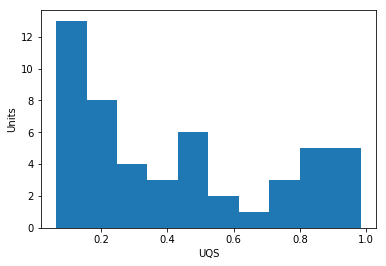

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(processed_results["units"]["metric2"])
plt.xlabel("UQS")
plt.ylabel("Units")

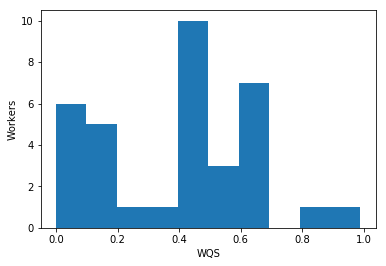

In [6]:
plt.hist(processed_results["workers"]["metric2"])
plt.xlabel("WQS")
plt.ylabel("Workers")

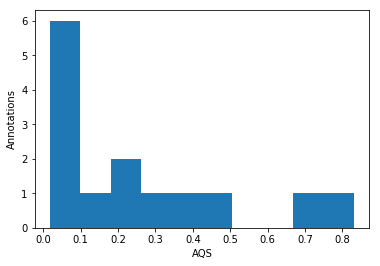

In [8]:
plt.hist(processed_results["annotations"]["metric2"])
plt.xlabel("AQS")
plt.ylabel("Annotations")